<a href="https://colab.research.google.com/github/nathqueiroz/sqlcompython/blob/desenvolvimento/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [6]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [7]:
#leitura dos arquivos
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [8]:
#criando um banco de dados localmente para armazenar as tabelas
engine = create_engine('sqlite:///:memory:')


In [9]:
#adicionando as tabelas no banco de dados criado
produtos.to_sql('produtos', engine, index=False)

205

In [10]:
#adicionando as outas tabelas
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [11]:
#verificando se as tabelas foram adicionadas
inspector = inspect(engine)
inspector.get_table_names()

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']

# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [12]:
# consulta para selecionar a coluna produtos
query = ' SELECT CONDICAO FROM PRODUTOS'

In [13]:
#conectando a um banco de dados usando o engine
with engine.connect() as conexao:
    consulta = conexao.execute(text(query)) #executa a consulta definida na query usando o text para interpretar como texto SQL
    dados = consulta.fetchall() #usa do fetchall p recuperar resultados da consulta armazenando na variável dados.

#criando o dataframe
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [14]:
#transformando em função para trabalhar mais vezes com esse df

def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [15]:
#agrupando as categorias por quantidade que elas aparecem na coluna condição

query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO'''
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


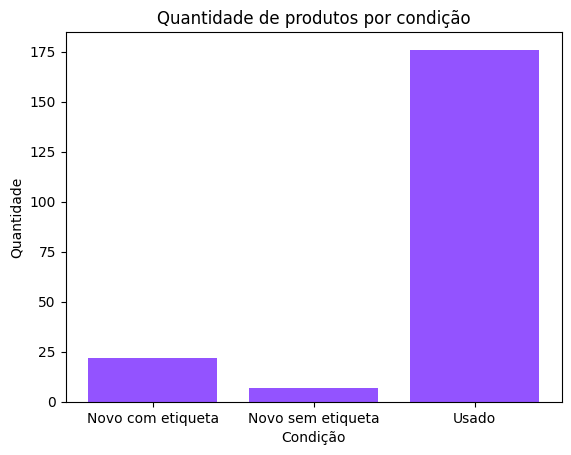

In [16]:
#criando um gráfico em colunas para o agrupamento

plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Quantidade de produtos por condição')
plt.xlabel('Condição')
plt.ylabel('Quantidade')
plt.show()

Projeto com Pandas: selecionando colunas, agrupando e contando

In [17]:
pd.DataFrame(produtos['Condicao'])

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [18]:
produtos.groupby('Condicao').size().reset_index(name='Quantidade')

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [19]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [20]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [21]:
#relacionando as tabelas
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC '''

df_prod_quant = sql_df(query)
df_prod_quant

,produto_id,produto,Quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,11218,Calca Alfaiataria Preta,750
198,72667,Saia Pregas Preta,751
199,98640,Calca Jeans Costuras,755


Text(0, 0.5, 'Produto')

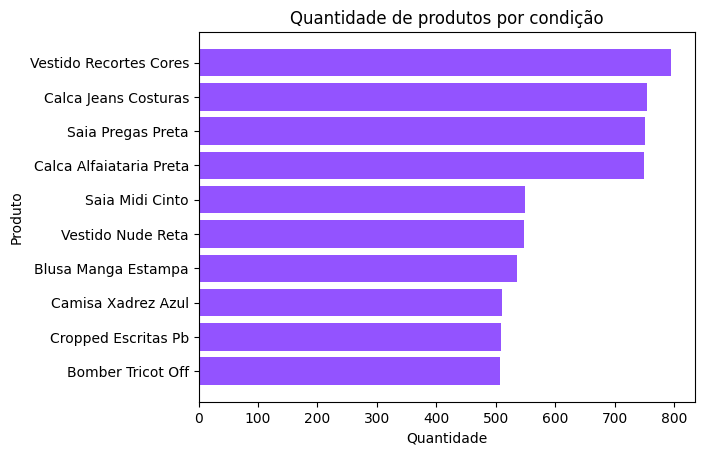

In [22]:
#criando um gráfico
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['Quantidade'][-10:], color='#9353FF')
plt.title('Quantidade de produtos por condição')
plt.xlabel('Quantidade')
plt.ylabel('Produto')

Projeto com Pandas #2: selecionando e relacionando os dados

In [23]:
#lendo os dados da tabela produtos e itens_pedidos
produtos.head(3)

itens_pedidos.head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [24]:
#relacionando as tabelas usando o merge
df_prod_quant = itens_pedidos.merge(produtos, on='produto_id')
df_prod_quant = df_prod_quant.groupby('produto')['quantidade'].sum().reset_index()
df_prod_quant = df_prod_quant.sort_values('quantidade', ascending=True).reset_index(drop=True)
df_prod_quant

,produto,quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


DESAFIO 1

Capturando a receita total de vendas de itens

In [25]:
#selecionando a coluna valor total da tabela itens_pedidos em uma query enviada na função sql_df
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita = df_itens_pedidos['valor_total'].sum()
receita

45803930

Desafio 2

Selecionando as marcas mais pedidas

In [26]:
#selecionando as marcas da tabela produtos, agrupando e ordenando os dados, para obter as marcas mais vendidas.
query = '''SELECT PRODUTOS.MARCA, COUNT (*) AS 'Pedidos'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC;
'''
df_marcas = sql_df(query)
df_marcas

,marca,Pedidos
0,Talie Nk,94
1,Track & Field,96
2,Ateliê de Calças,99
3,Bottega Veneta,101
4,Bcbgmaxzria,103
...,...,...
112,Banana Republic,584
113,Le Lis Blanc,715
114,Animale,1128
115,Mixed,1673


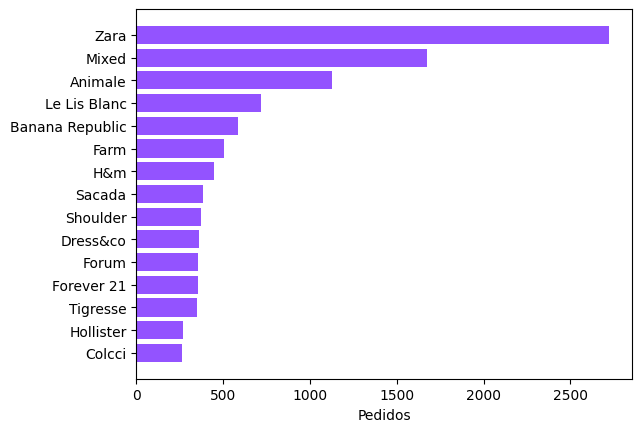

In [27]:
#plotando o gráfico
plt.barh(df_marcas['marca'][-15:], df_marcas['Pedidos'][-15:], color = '#9353FF')
plt.xlabel('Pedidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [28]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [29]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [33]:
#selecionando apenas os dados do ano de 2020
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID

--agrupando por nome do vendedor
GROUP BY VENDEDORES.NOME_VENDEDOR

--ordenando por quantidade de vendas em ordem decrescente
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


  Projeto com pandas

In [35]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''

In [36]:
df_filtrado = pedidos[pedidos['data_compra'].str.startswith('2020')]
df_mesclado = df_filtrado.merge(vendedores, on='vendedor_id')
df_agrupado = df_mesclado.groupby('nome_vendedor')['total'].mean().reset_index()
df_filtro_data = df_agrupado.sort_values('total', ascending=False).reset_index(drop=True)
df_filtro_data.columns = ['nome_vendedor', 'Valor médio por vendas']
df_filtro_data

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.